<a href="https://colab.research.google.com/github/pedro21900/fase_4_tech_challenge/blob/main/fase_4_tech_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tech Challenge Fase 4 🎓

### Sobre a base de dados 🎲

A base de dados do **yfinance** (Yahoo Finance) é uma API em Python que fornece acesso a uma ampla gama de informações financeiras do mercado. Ela permite obter dados históricos de preços de ações,fundos, modedas e criptomoedas, bem  como informações fundamentais e estatísticas de mercado, como:

<ol>
    <li><b>Preços históricos:</b> Abertura, fechamento, alta, baixa e volume negociado,com suporte para intevelos variados (dia,semana, mês) </li>
    <li><b>Dados fundamentais:<b/> Dividendos, splits de ações, balanços financeiros, lucros e métricas como P/E ratio.</li>
    <li><b>Dados em tempo real:</b> Preços de mercado atualizados (dependendo das limitações de atraso e região).</li>
    <li><b>Informações de mercado:</b> Volatilidade, beta, valor de mercado e outros indicadores.</li>
</ol>    

O yfinance pe amplamente ultilizado devido à facilidade de integração com pandas e à abrangência dos daos oferecidos, tornando-se uma ferramente insdispensável para análise quantitativa, estratégica de investimento e pesquisa financeira

Objetivo 🚀

Desenvolver um modelo preditivo ultilizando redes neurais LSTM (Long Short Term Memory) para predizer o valor de fechamento da bolsa de valores da **Disney**.

### Instalando Bibliotecas

In [ ]:
!pip install mlflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install scikit-learn
!pip install torch
!pip install seaborn

### Importando bibliotecas

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mlflow
import mlflow.pytorch
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score
import joblib
import os

PATH = './resources'

### Baixando dataset do yfinance

Este techo de código configura o **yfinance** para baixar o histórico de 01/01/2018 a 20/07/2024 do ticket **'DIS' (Disney)**

In [3]:
# Baixar os dados históricos para o ticker PETR4
df = yf.download('DIS')
len(df)

[*********************100%***********************]  1 of 1 completed


15837

### Análise dos dados

Neste trecho, plotamos o volume anual, onde é possível observar que, em 2021, houve um aumento significativamente fora do padrão, podendo ser considerado um outlier.

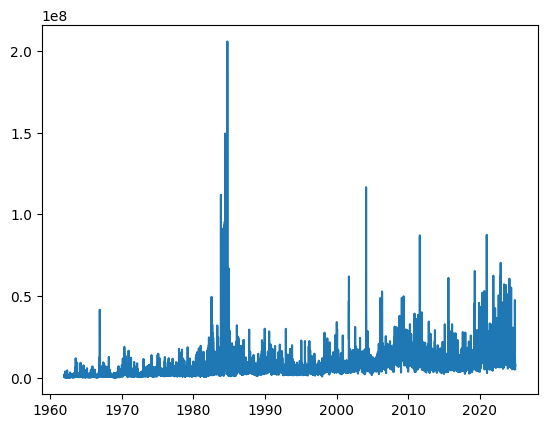

In [4]:
timeseries = df[["Volume"]].values.astype('float32')

plt.plot(df.index, timeseries)
plt.show()

Neste trecho, plotamos o heatmap para encontrar a combinação mais relevante dos dados em relação ao fechamento da bolsa de valores

<Axes: >

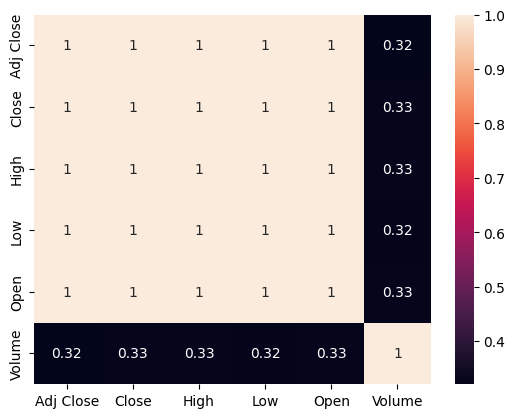

In [5]:
df.columns = ['_'.join(col).replace('_DIS', '').strip() if isinstance(col, tuple) else col for col in df.columns]
sns.heatmap( df.corr(), annot = True)


Percebemos que o único campo com uma baixa correlação de informações relevantes é o `volume`, enquanto os demais influenciam diretamente os valores de saída.

#### Pré processamento dos dados

In [7]:
# Remoção dos inices de data
df =  df.reset_index()
df = df.drop(columns=['Date'])

# Isolamento dos dados para entra X e saida Y
X = df.drop(columns=['Close']).values.astype(np.float32)
Y = df[['Close']].values.astype(np.float32)

# Normalizando dados
scalerX = StandardScaler()
scalerY = StandardScaler()
X = scalerX.fit_transform(X)
Y = scalerY.fit_transform(Y)

# Salvando artefato dos normalizadores de dados
joblib.dump(scalerX, f'{PATH}/scalerX.pkl')
joblib.dump(scalerY, f'{PATH}/scalerY.pkl')

['./resources/scalerY.pkl']

#### Criando diretório para organização dos artefatos

In [21]:
try:
    os.mkdir(PATH)
    print(f"Directory '{PATH}' created successfully.")
except FileExistsError:
    print(f"Directory '{PATH}' already exists.")


Directory './resources' already exists.


### Construindo o modelo

Após algumas tentativas verificamos que essa é a mlehor combinação de hiperparâmetos do modelo

In [8]:
input_size = 5
hidden_size = 100
num_layers = 4
output_size = 1
learning_rate = 0.01
num_epochs = 10
batch_size = 64

#### Criando o modelo RNN com LSTM

In [15]:
# Modelo LSTM com arquitetura sequencial
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=100, num_layers=4, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # Passa os dados pelo modelo sequencial
        output, _ = self.lstm(x)

        return self.fc(output)

#### Convertendo o dataframe para um dataset

In [16]:
# Dataset para treinamento
class YfinanceTrainDataset(Dataset):
    def __init__(self, x, y):
        super(YfinanceTrainDataset, self).__init__()

        self.data = x
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

#### Configurando treinamento do modelo

In [17]:
# Dispositivo (CPU ou GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Funções de treinamento e avaliação
def train_model(train_loader, test_loader):
    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    mlflow.set_experiment("LSTM Artificial Data Regression")
    with mlflow.start_run():
        mlflow.log_param("input_size", input_size)
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("output_size", output_size)
        mlflow.log_param("num_epochs", num_epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for i, (sequences, labels) in enumerate(train_loader):
                sequences, labels = sequences.to(device), labels.to(device)

                # Forward pass
                outputs = model(sequences)
                loss = criterion(outputs, labels)

                # Backward pass e otimização
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 100 == 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
                    mlflow.log_metric("train_loss", running_loss / (i+1), step=epoch * len(train_loader) + i)

        mlflow.pytorch.log_model(model, "lstm_artificial_data_model")
        evaluate_model(model, test_loader)
        return model


def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = nn.MSELoss()(outputs, labels)
            test_loss += loss.item()

    average_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {average_test_loss:.4f}")
    mlflow.log_metric("test_loss", average_test_loss)

In [18]:
dataset = YfinanceTrainDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model = train_model(train_loader, test_loader)
torch.save(model.state_dict(), f'{PATH}/model.pt')

Epoch [1/10], Step [1/248], Loss: 0.9252
Epoch [1/10], Step [101/248], Loss: 0.0109
Epoch [1/10], Step [201/248], Loss: 0.0056
Epoch [2/10], Step [1/248], Loss: 0.0042
Epoch [2/10], Step [101/248], Loss: 0.0004
Epoch [2/10], Step [201/248], Loss: 0.0010
Epoch [3/10], Step [1/248], Loss: 0.0016
Epoch [3/10], Step [101/248], Loss: 0.0007
Epoch [3/10], Step [201/248], Loss: 0.0047
Epoch [4/10], Step [1/248], Loss: 0.0038
Epoch [4/10], Step [101/248], Loss: 0.0019
Epoch [4/10], Step [201/248], Loss: 0.0008
Epoch [5/10], Step [1/248], Loss: 0.0022
Epoch [5/10], Step [101/248], Loss: 0.0003
Epoch [5/10], Step [201/248], Loss: 0.0026
Epoch [6/10], Step [1/248], Loss: 0.0006
Epoch [6/10], Step [101/248], Loss: 0.0008
Epoch [6/10], Step [201/248], Loss: 0.0008
Epoch [7/10], Step [1/248], Loss: 0.0030
Epoch [7/10], Step [101/248], Loss: 0.0031
Epoch [7/10], Step [201/248], Loss: 0.0020
Epoch [8/10], Step [1/248], Loss: 0.0024
Epoch [8/10], Step [101/248], Loss: 0.0016
Epoch [8/10], Step [201/248

2024/11/30 21:52:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/30 21:52:59 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/30 21:52:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test Loss: 0.0014


### Testando modelo

Para realizar o teste do modelo, seguimos os seguintes passos:

1. **Carregar o modelo treinado**: Utilizamos o PyTorch para carregar os pesos salvos previamente.
2. **Carregar os normalizadores de dados**: Lemos os arquivos do `joblib` para normalizar e desnormalizar os dados.
3. **Criar dados fictícios para inferência**: Simulamos uma entrada no formato esperado pelo modelo.
4. **Normalizar os dados de entrada**: Ajustamos os valores para a escala utilizada durante o treinamento.
5. **Converter os dados em tensores**: Transformamos os dados normalizados em tensores PyTorch, compatíveis com o modelo.
6. **Realizar a inferência**: Passamos os dados pelo modelo para obter a previsão.
7. **Desnormalizar os resultados**: Retornamos os valores para sua escala original, permitindo interpretação.


In [20]:
model =  LSTMModel()
model.load_state_dict(torch.load(f'{PATH}/model.pt', weights_only=True))
model.eval()

# Lendo padronizador de dados
scalerx = joblib.load(f'{PATH}/scalerX.pkl')
scalery = joblib.load(f'{PATH}/scalerY.pkl')

# Exemplo de entrada
entrada = np.array([[107.875183,		111.809998,	108.559998,	108.949997,	11014300]], dtype=np.float32)

# Transformação dos dados
entrada_normalizada = scalerx.transform(entrada)

# Converte para tensor e ajusta para o formato esperado pelo modelo (batch_size=1, seq_len=1, input_size=4)
entrada_tensor = torch.tensor(entrada_normalizada, dtype=torch.float32).unsqueeze(0).to(device)

# Obtenha o resultado do modelo
result = model(entrada_tensor)  # Certifique-se de que model é uma função ou objeto chamável

# Desconecte o tensor do grafo computacional e converta para NumPy
result_numpy = result.detach().cpu().numpy()  # Use `.cpu()` se o tensor estiver na GPU

# Desnormalização
result_desnormalizado = scalery.inverse_transform(result_numpy[0])

print(result_desnormalizado)


[[109.70788]]
